In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
# Import Statsmodels
from statsmodels.tsa.api import VAR
import svarlr
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/murphy-k/svarlr/master/Germany.csv")

In [3]:
df.index = df.Year
df = df.drop(['Year'],axis=1)

In [4]:
df

,TFP,TotHrGrowth
Year,,
1951-01-01,6.894657,1.037311
1952-01-01,5.080555,0.634502
1953-01-01,4.542223,1.454624
1954-01-01,3.185142,1.806637
1955-01-01,5.412597,2.032252
...,...,...
2012-01-01,-0.346423,-0.127787
2013-01-01,-0.059366,-0.288752
2014-01-01,0.591983,1.158355


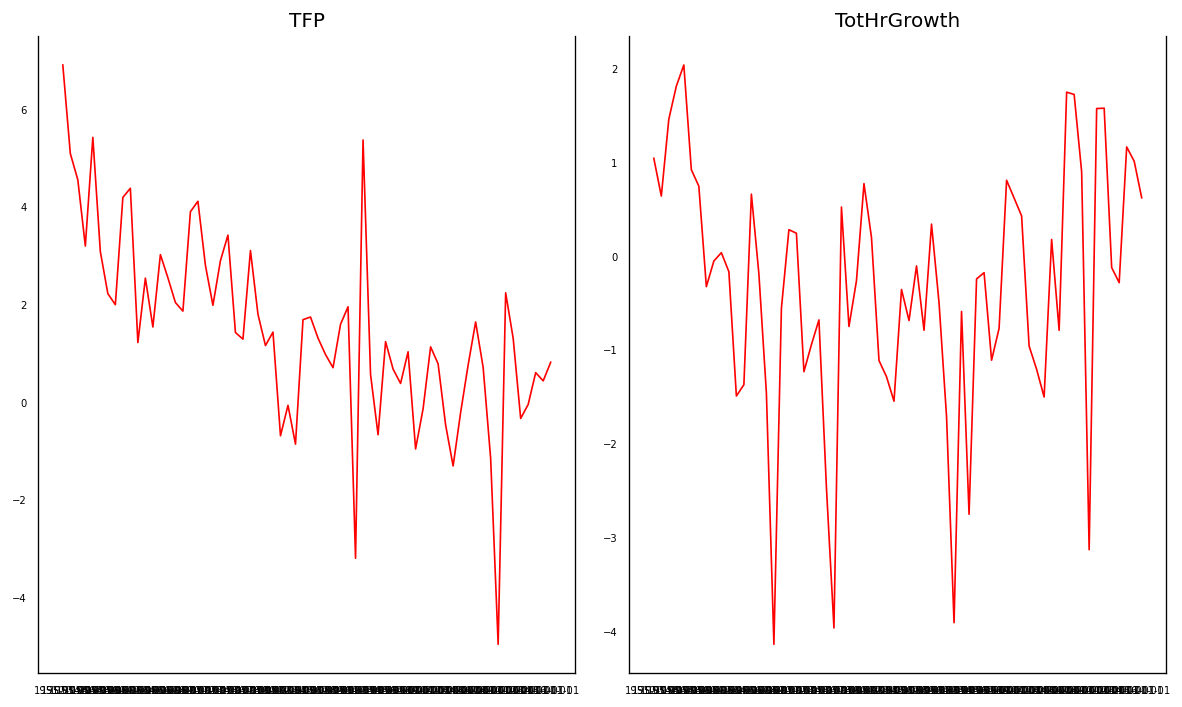

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [5]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Compruebe la causalidad de Granger de todas las combinaciones posibles de la serie temporal.
    Las filas son la variable de respuesta, las columnas son predictores. Los valores de la tabla 
    son los valores P. Valores p menores que el nivel de significancia (0,05), implica 
    la hipótesis nula de que los coeficientes de los valores pasados correspondientes son 
    cero, es decir, la X no causa Y puede ser rechazada.



    Datos : Dataframe de pandas que contiene las variables de series temporales
    variables : lista que contiene los nombres de las variables de serie temporal.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False) # maxlag: retrasos
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,TFP_x,TotHrGrowth_x
TFP_y,1.000,0.0008
TotHrGrowth_y,0.001,1.0000


In [6]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
TFP    ::  17.98     > 12.3212   =>   True
TotHrGrowth ::  4.57      > 4.1296    =>   True


In [7]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [8]:
for name, column in df.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "TFP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1898
 No. Lags Chosen       = 5
 Critical value 1%     = -3.544
 Critical value 5%     = -2.911
 Critical value 10%    = -2.593
 => P-Value = 0.21. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "TotHrGrowth" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5807
 No. Lags Chosen       = 0
 Critical value 1%     = -3.535
 Critical value 5%     = -2.907
 Critical value 10%    = -2.591
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




In [9]:
# 1st difference
df_differenced = df.diff().dropna()

In [10]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "TFP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.3278
 No. Lags Chosen       = 4
 Critical value 1%     = -3.544
 Critical value 5%     = -2.911
 Critical value 10%    = -2.593
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "TotHrGrowth" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.3983
 No. Lags Chosen       = 6
 Critical value 1%     = -3.548
 Critical value 5%     = -2.913
 Critical value 10%    = -2.594
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




# Otra forma (M)

In [15]:
model_o = VAR(df[1:])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


In [16]:
sorted_order=model_o.select_order(maxlags=12)
print(sorted_order.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        1.769       1.843       5.863       1.797
1        1.641       1.864       5.164       1.727
2       1.443*      1.815*      4.239*      1.586*
3        1.514       2.034       4.558       1.714
4        1.645       2.314       5.217       1.903
5        1.597       2.414       4.997       1.911
6        1.699       2.666       5.584       2.071
7        1.647       2.763       5.361       2.076
8        1.692       2.956       5.694       2.179
9        1.809       3.222       6.528       2.353
10       1.850       3.411       6.969       2.450
11       1.974       3.684       8.143       2.632
12       1.960       3.819       8.353       2.675
--------------------------------------------------


In [17]:
model = VAR(df)
model_fitted = model.fit(1)
model_fitted.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  warnings.warn('No frequency information was'


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 28, Nov, 2022
Time:                     15:08:30
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    1.80409
Nobs:                     65.0000    HQIC:                   1.68257
Log likelihood:          -230.572    FPE:                    4.97045
AIC:                      1.60338    Det(Omega_mle):         4.54155
--------------------------------------------------------------------
Results for equation TFP
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.640847         0.282983            2.265           0.024
L1.TFP                 0.448027         0.109890            4.077           0.000
L1.TotHrGrowth        -0.285380         0.160372          

La correlación en serie de los residuos se utiliza para comprobar si hay algún patrón sobrante en los residuos (errores).

Si queda alguna correlación en los residuos, entonces, hay algún patrón en la serie de tiempo que aún queda por explicar por el modelo. En ese caso, el curso de acción típico es aumentar el orden del modelo o inducir más predictores en el sistema o buscar un algoritmo diferente para modelar la serie temporal.

Por lo tanto, verificar la correlación en serie es garantizar que el modelo sea lo suficientemente capaz de explicar las varianzas y los patrones en las series temporales.

El valor de esta estadística puede variar entre 0 y 4. Cuanto más cerca esté del valor 2, entonces no hay una correlación serial significativa. Cuanto más cerca de 0, hay una correlación serial positiva, y cuanto más cerca está de 4 implica correlación serial negativa

In [18]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

TFP : 2.32
TotHrGrowth : 1.96


In [30]:
model_fitted.is_stable(model_fitted.coefs, False)

TypeError: is_stable() takes from 1 to 2 positional arguments but 3 were given

In [35]:
model_fitted.

<bound method VARProcess.mean of <statsmodels.tsa.vector_ar.var_model.VARResults object at 0x0000018D6AABF880>>